In [379]:
import pandas as pd
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from copy import deepcopy as dcopy

In [380]:
np.set_printoptions(precision=3)

#without using scientific number in numpy;
np.set_printoptions(suppress=True)
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

In [381]:
import os
cwd = os.getcwd()
os.chdir("interest_rate_risk")

In [382]:
import warnings
warnings.filterwarnings('ignore')

In [383]:
sap01=pd.read_excel("H:volatility\\raw_data.ods",engine='odf')

In [384]:
sap01.head()

,Date,S&P
0,2005-07-18,1221.13
1,2005-07-19,1229.35
2,2005-07-20,1235.20
3,2005-07-21,1227.04
4,2005-07-22,1233.68


In [388]:
sap01.columns=['date','value']
sap01.shape

(1279, 2)

In [389]:
sap02=sap01.shift()
sap01['value_last_day']=sap02.value
sap03=sap01.iloc[1:,:]
sap03['return']=sap03.value/sap03.value_last_day-1

In [390]:
sap03.head()

,date,value,value_last_day,return
1,2005-07-19,1229.35,1221.13,0.006731
2,2005-07-20,1235.20,1229.35,0.004759
3,2005-07-21,1227.04,1235.20,-0.006606
4,2005-07-22,1233.68,1227.04,0.005411
5,2005-07-25,1229.03,1233.68,-0.003769


In [391]:
# plot first 1000 days of S&P500 daily return starting on July,18,2005;

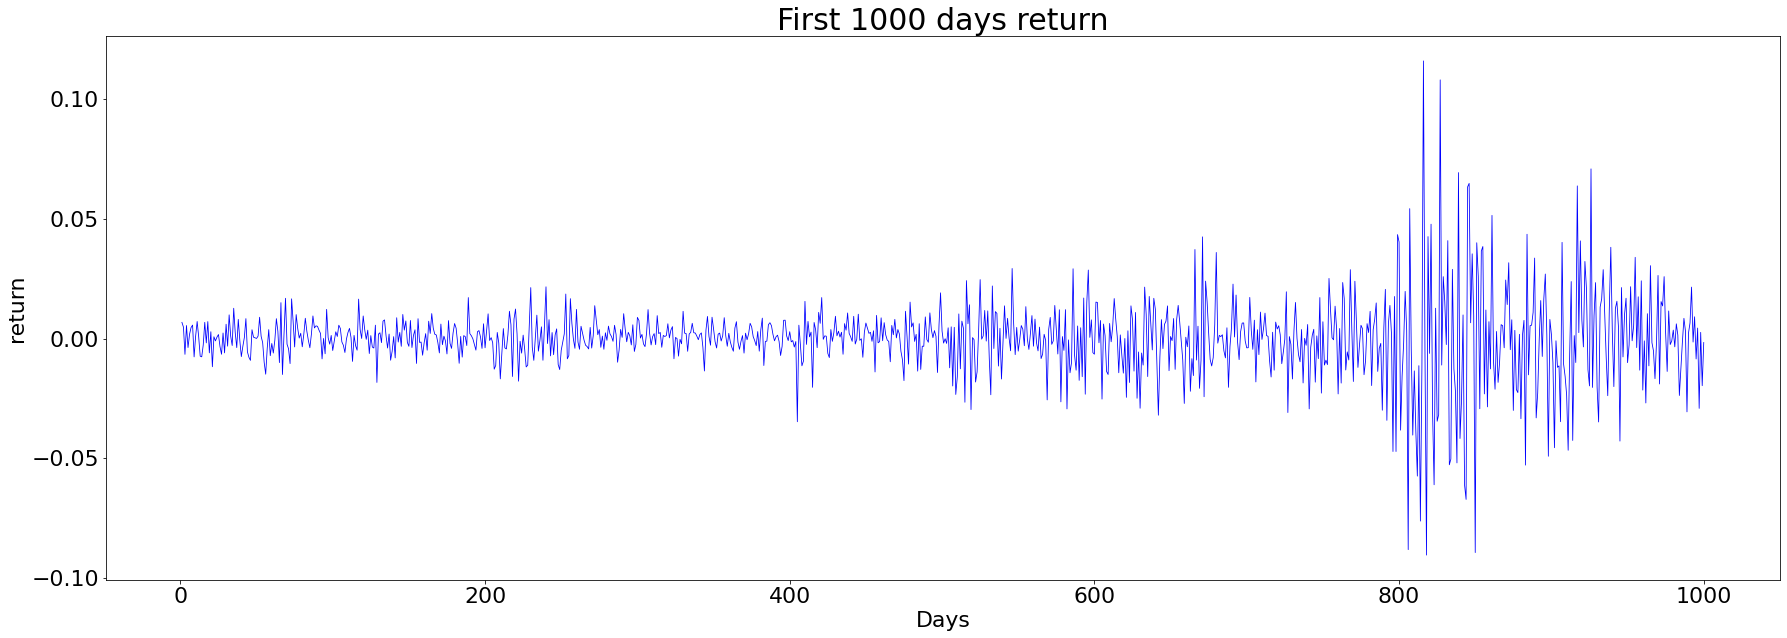

In [392]:
plt.plot([i for i in range(1,1001)], sap03.loc[0:1000,'return'].to_list(),c='blue',linewidth=0.8)

plt.rcParams["figure.figsize"] = (30,8)
plt.xlabel("Days", fontsize=22)
plt.ylabel("return", fontsize=22)
plt.rcParams.update({'font.size': 22})
plt.title('First 1000 days return',fontsize=30)
plt.show()
plt.close()

In [393]:
# it seems clear that returns are more volatile in some time periods than others
# variance of return isn't constant, especially in later periods, so this return series 
# is non-stationary;
# we can plot absolute returns to see more clearly;

In [394]:
r_abs=[abs(r) for r in sap03['return'].to_list()]

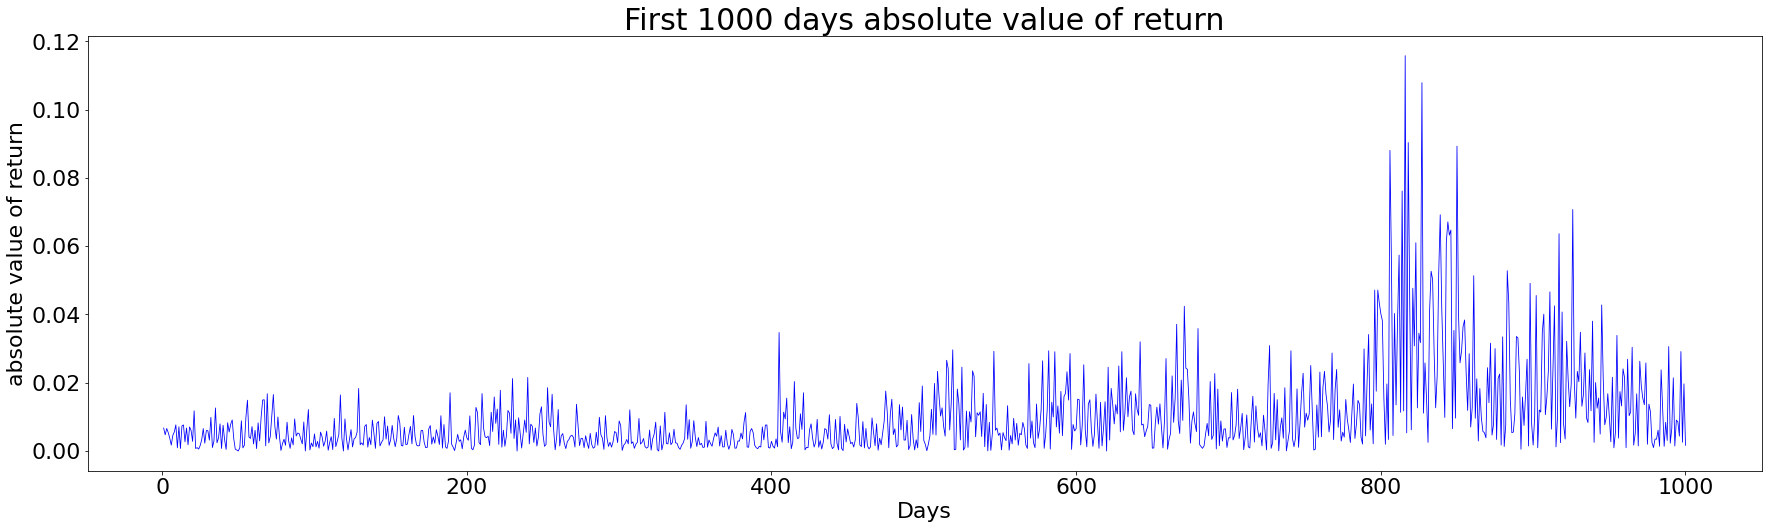

In [395]:
plt.plot([i for i in range(1,1001)], r_abs[0:1000],c='blue',linewidth=0.8)

plt.rcParams["figure.figsize"] = (30,8)
plt.xlabel("Days", fontsize=22)
plt.ylabel("absolute value of return", fontsize=22)
plt.rcParams.update({'font.size': 22})
plt.title('First 1000 days absolute value of return',fontsize=30)
plt.show()
plt.close()

In [396]:
# clearly we see some 'volatility clustering' in the chart; 

in stock return example, the average return $\bar u$ is assumed to be zero, we now test if this is true.

In [397]:
temp_col=sap03['return'].to_list()

In [398]:
print('%f' % ( np.mean(temp_col) ),'%f' % ( np.std(temp_col) ))

0.000024 0.015525


In [399]:
# the standard deviation is much larger than the mean, which indicates the mean is not statistically
# significant from 0! therefore our assumption of zero average return isn't unreasonable.

In [400]:
# to check if there are autocrorrelctions in return series, using ADF test;

In [401]:
from statsmodels.tsa.stattools import adfuller

In [402]:
adf_result=adfuller(sap03['return'])

In [403]:
print('adf result:',round(adf_result[0],3),'    adf p value:',round(adf_result[1],3))

adf result: -7.407     adf p value: 0.0


In [404]:
# so null-hypothesis is rejected and it is non-stationary. we can plot autocorrelation below;

In [405]:
from statsmodels.graphics.tsaplots import plot_acf

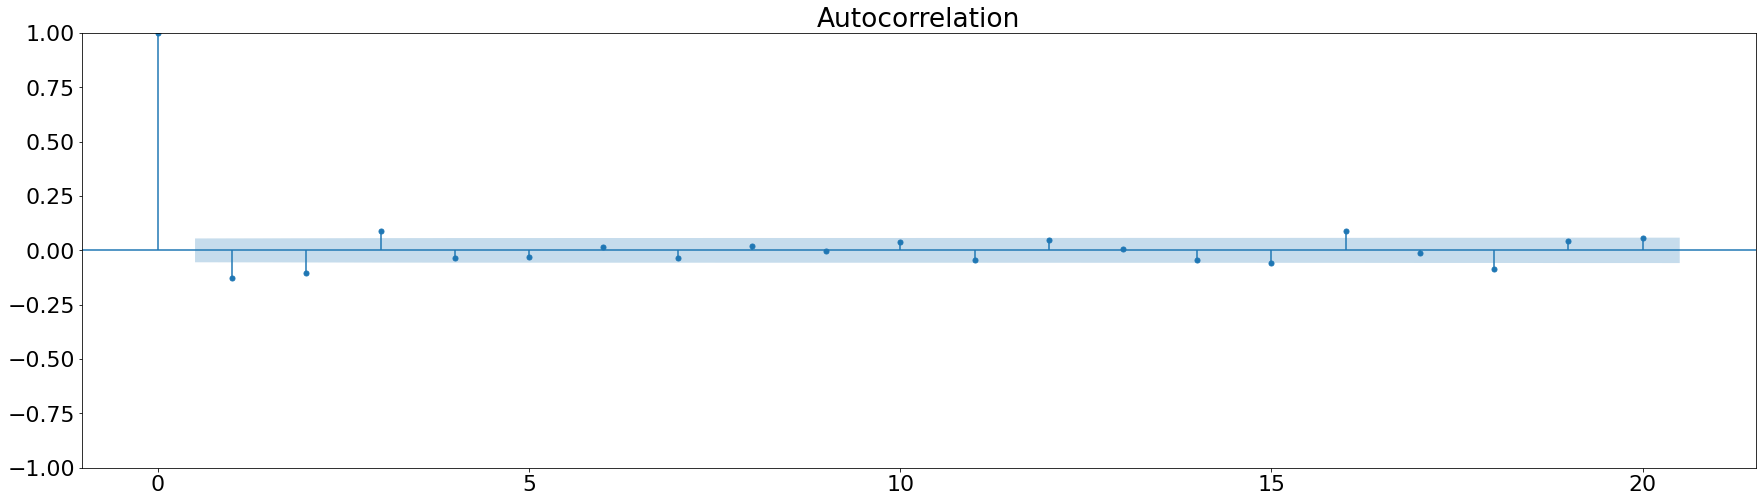

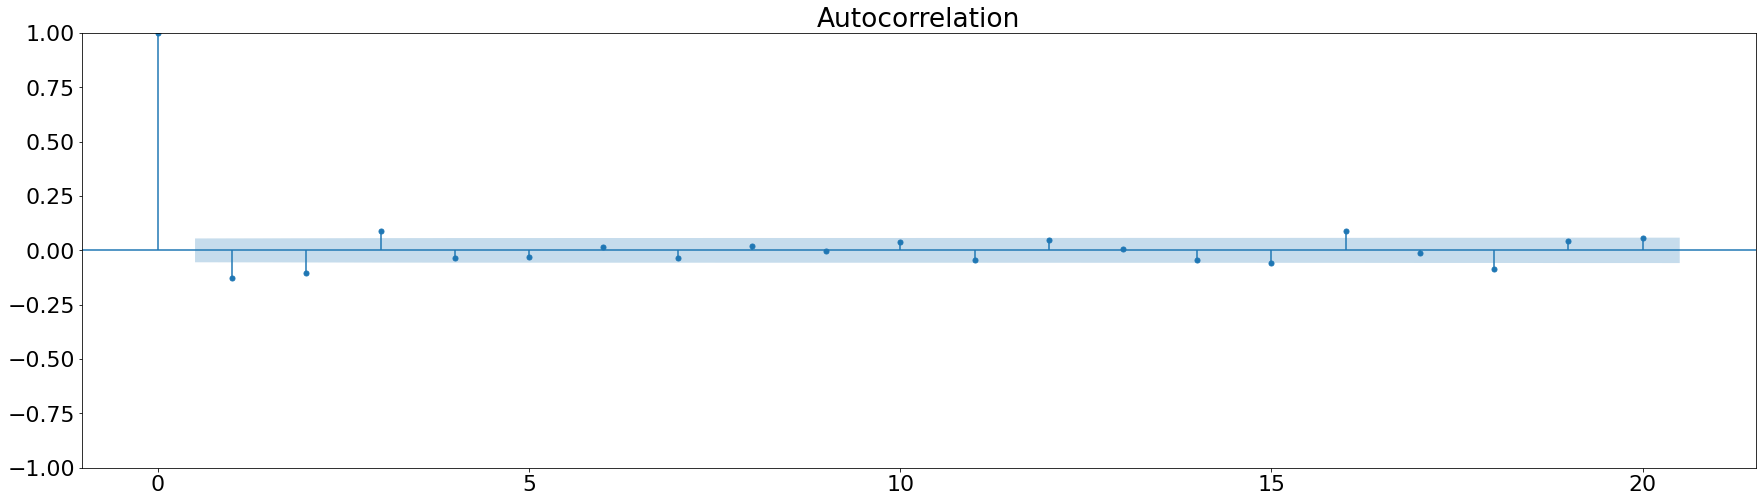

In [406]:
plot_acf(sap03['return'],lags=20)

In [407]:
# shows there is little serial correlation. 

In [408]:
# consider that the variance of return isn't constant and exhibits "volatility clustering", so will
# use GARCH model for its variance prediction. 

In [409]:
# GARCH(1,1) model is popular for return volatilities:

 GARCH(1,1):  $ \sigma_t ^2=\gamma *V_L+\alpha*u_{t-1}^2 +\beta*\sigma_{t-1}^2 \text{  }, 
\text{ } V_L \text{ is long-run average variance.} \text{     } Also, \gamma+\alpha+\beta=1, \text{and  } \omega=\gamma* V_L;$ 
$ r_t =\epsilon_t*\sigma_t\text{.  }$

we need to estimate $\beta \text{ and } \gamma \text{ only, since } \alpha=1-\beta-\gamma .$\
to maximum below likelihood summation: 
\
\
$ \large \sum\limits_{i=1}^{m}[-ln(v_i)-\frac{u_i^ 2}{v_i}] $

In [410]:
temp_col.insert(0,-99)
temp_col=temp_col[0:-1]
len(temp_col)

1278

In [414]:
sap03['return_last_day']=temp_col
sap04=sap03.iloc[1:,:]

In [413]:
sap04.head()

,date,value,value_last_day,return,return_last_day
2,2005-07-20,1235.20,1229.35,0.004759,0.006731
3,2005-07-21,1227.04,1235.20,-0.006606,0.004759
4,2005-07-22,1233.68,1227.04,0.005411,-0.006606
5,2005-07-25,1229.03,1233.68,-0.003769,0.005411
6,2005-07-26,1231.16,1229.03,0.001733,-0.003769


In [415]:
comb=list(zip(sap04['return'].to_list(), sap04['return_last_day'].to_list()))

In [416]:
date_day=[x.strftime("%m/%d/%Y") for x in sap04.date.to_list()]


In [417]:
sap04_dict=dict(zip(date_day,comb))

In [418]:
#long-term variance of return series is:
VL_long=np.var(sap03['return'][0:1278])
print(round(VL_long,6))

0.000241


In [420]:
return_last_day_list=sap04['return_last_day'].to_list()

 maximum likelihood function with grid search for $\omega$ and $\beta$:

In [421]:
def likelihood_func(omega,beta,datadict):
    global variance_list
    likelihood_list=[]
    variance_list=[]
    variance_initial=(0.004758)**2
    var_estimate=variance_initial
    gamma=omega/VL_long
    alpha=1-gamma-beta
    
    
  
    for key in datadict:
        var_estimate=omega+alpha*  ((datadict[key][1])**2)+beta*(var_estimate)
        variance_list.append(var_estimate)
        temp_likelihood=-np.log(var_estimate)-(  (datadict[key][0])**2  )/var_estimate
        likelihood_list.append(temp_likelihood)
    return likelihood_list

In [422]:
s=[]
n1=300000
n2=100

for om in range(1,n1):
    for beta in range(1,n2):
        gamma=(om/n1/0.000241)
        if 1-gamma-beta/n2>0:
            s.append([round(om/n1,8),round(beta/n2,8),'n,n2:',om,beta])

In [423]:
score=[]
for i in s:
    score.append([i[0],i[1],round(  sum(likelihood_func(i[0],i[1],sap04_dict)),1)])

In [424]:
score.sort(key=lambda x:x[2],reverse=True)

In [425]:
score[0:10]

[[3.33e-06, 0.87, 10215.5],
 [3.33e-06, 0.86, 10214.6],
 [3.33e-06, 0.88, 10214.5],
 [3.33e-06, 0.85, 10212.2],
 [3.33e-06, 0.89, 10211.4],
 [3.33e-06, 0.84, 10208.4],
 [3.33e-06, 0.9, 10205.6],
 [3.33e-06, 0.83, 10203.3],
 [3.33e-06, 0.82, 10197.2],
 [3.33e-06, 0.91, 10196.5]]

In [428]:
# from above result, maximum likelihood 10215.5 is achieved when omega=0.00000333 and beta=0.87.
# and gamma=omega/Vl=0.00000333/0.000241=0.014

In [429]:
likelihood_func(0.00000333,0.87,sap04_dict)
print(' ')

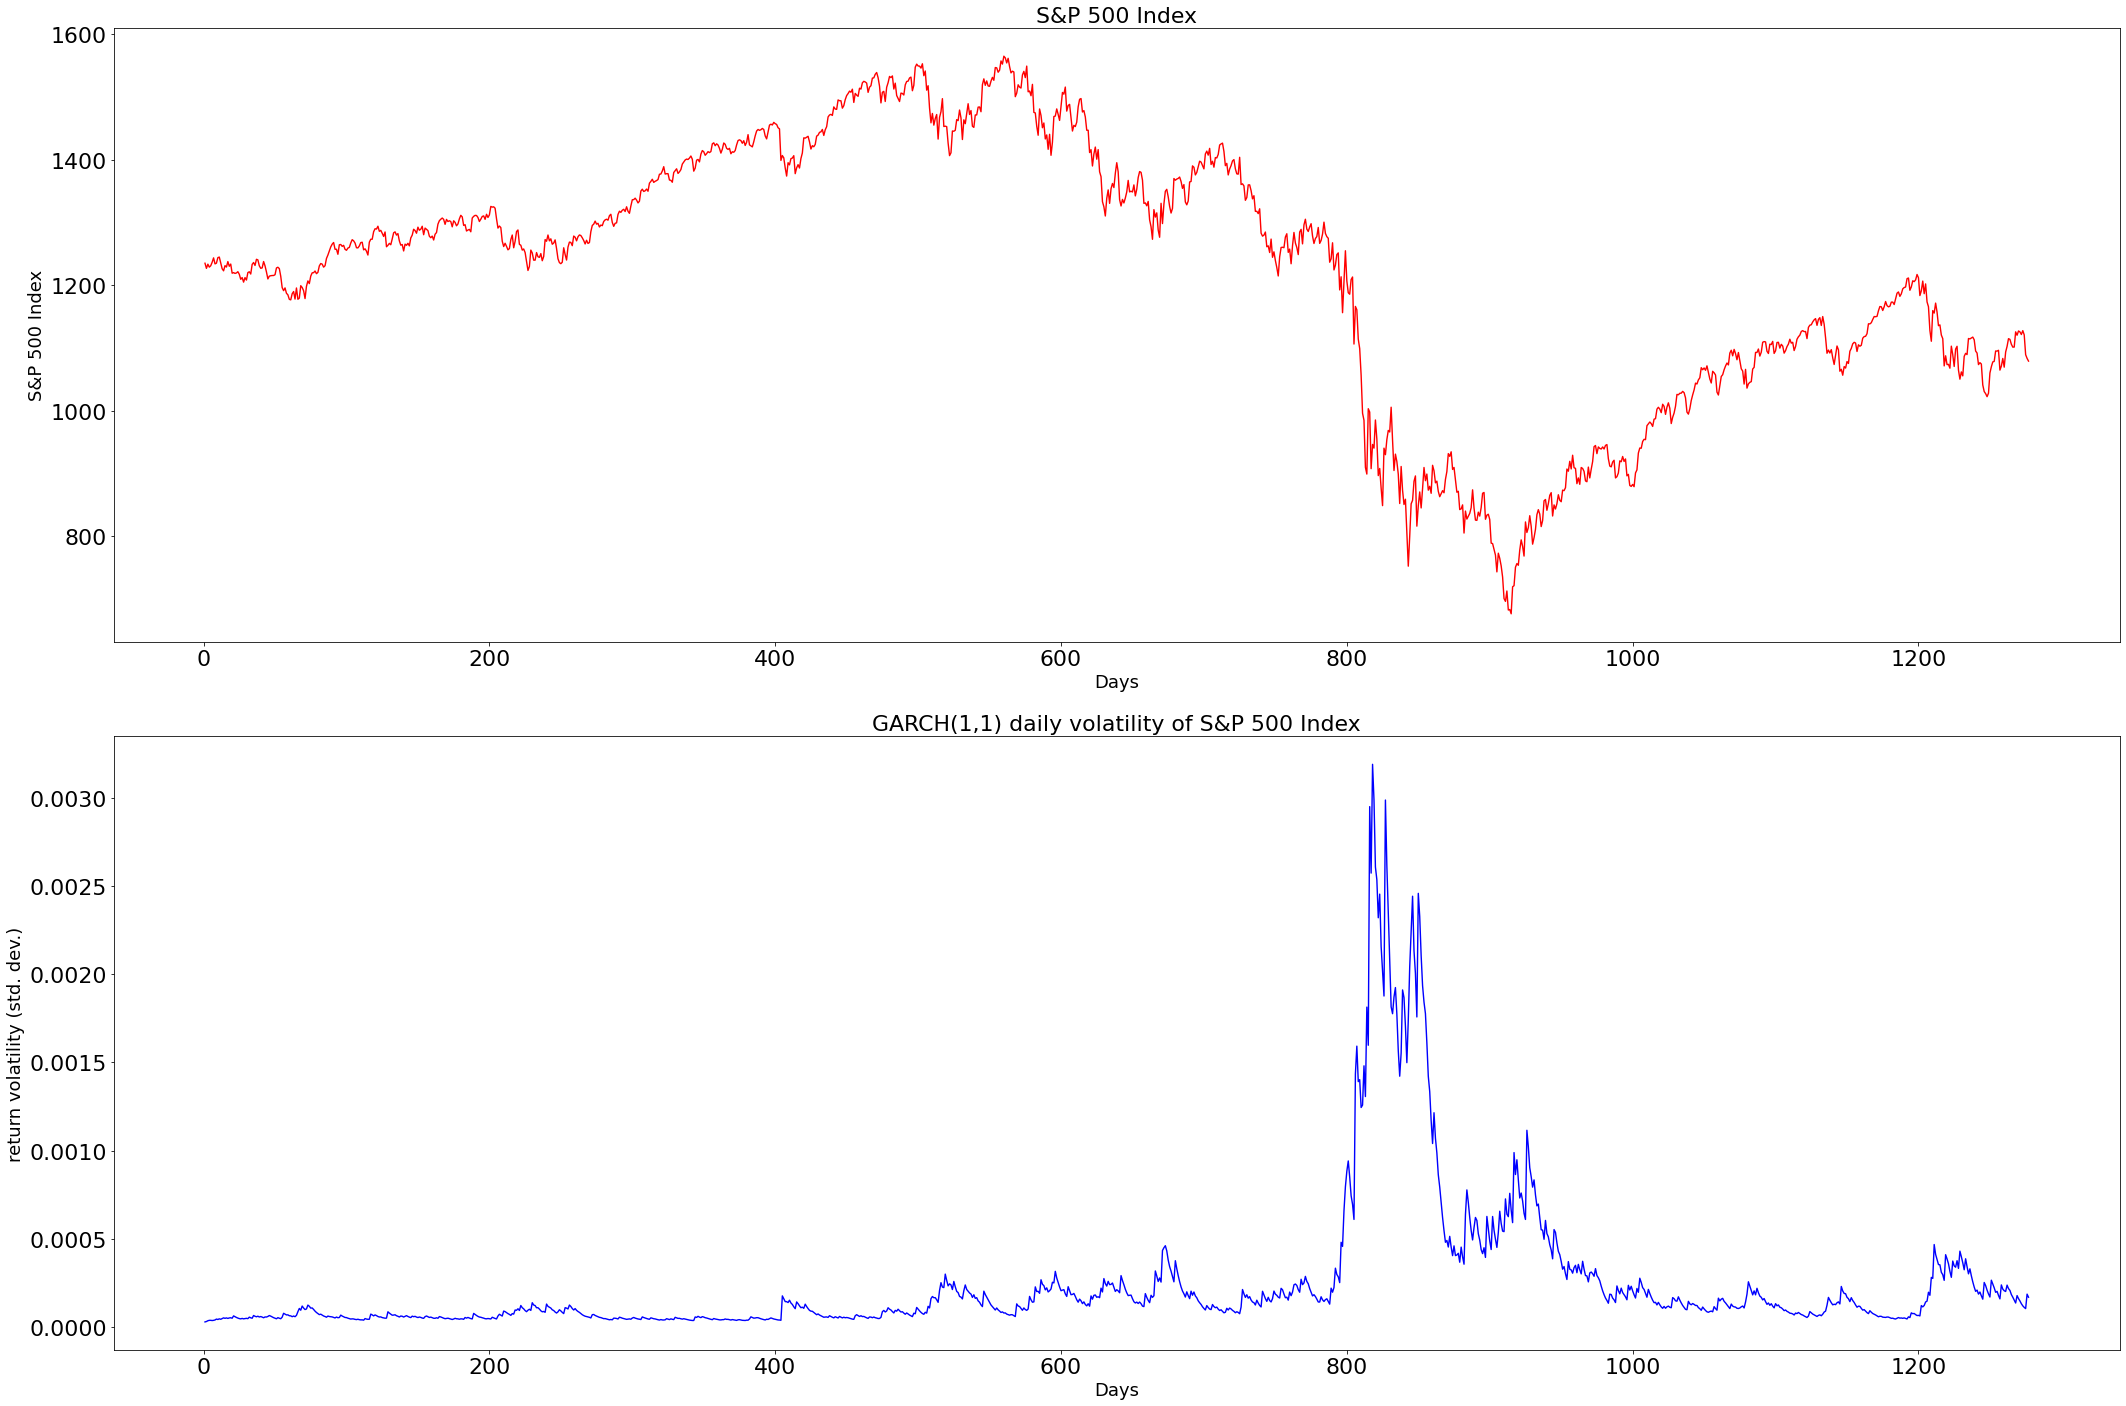

In [434]:
plt.subplot(2,1,1)
plt.plot([i for i in range(1,1278)], sap04.value.to_list(),c='red',linewidth=1.4)
figsize_tuple=(30,15)
plt.rcParams["figure.figsize"] =figsize_tuple
plt.xlabel("Days", fontsize=18)
plt.ylabel("S&P 500 Index", fontsize=18)
plt.rcParams.update({'font.size': 22})
plt.title('S&P 500 Index',fontsize=22)

plt.subplot(2,1,2)
plt.plot([i for i in range(1,1278)], variance_list[0:1277],c='blue',linewidth=1.4)
plt.rcParams["figure.figsize"] =figsize_tuple
plt.xlabel("Days", fontsize=18)
plt.ylabel("return volatility (std. dev.)", fontsize=18)
plt.rcParams.update({'font.size': 22})
plt.title('GARCH(1,1) daily volatility of S&P 500 Index',fontsize=22)
plt.tight_layout()
plt.show()
plt.close()

we evaluate our GARCH model by checking the autocorrelation structure for variables $\large \frac{u_i^2}{\sigma_i^2}$, if model works well, then it should remove the autocorrelation in variables $\large \frac{u_i^2}{\sigma_i^2}$.


In [435]:
import statsmodels.api as sm

In [436]:
return_square=[x**2 for x in sap04['return'].to_list()]
auto_corr01=sm.tsa.acf(return_square)[1:16]
auto_corr02=sm.tsa.acf(np.array(return_square)/np.array(variance_list))[1:16]

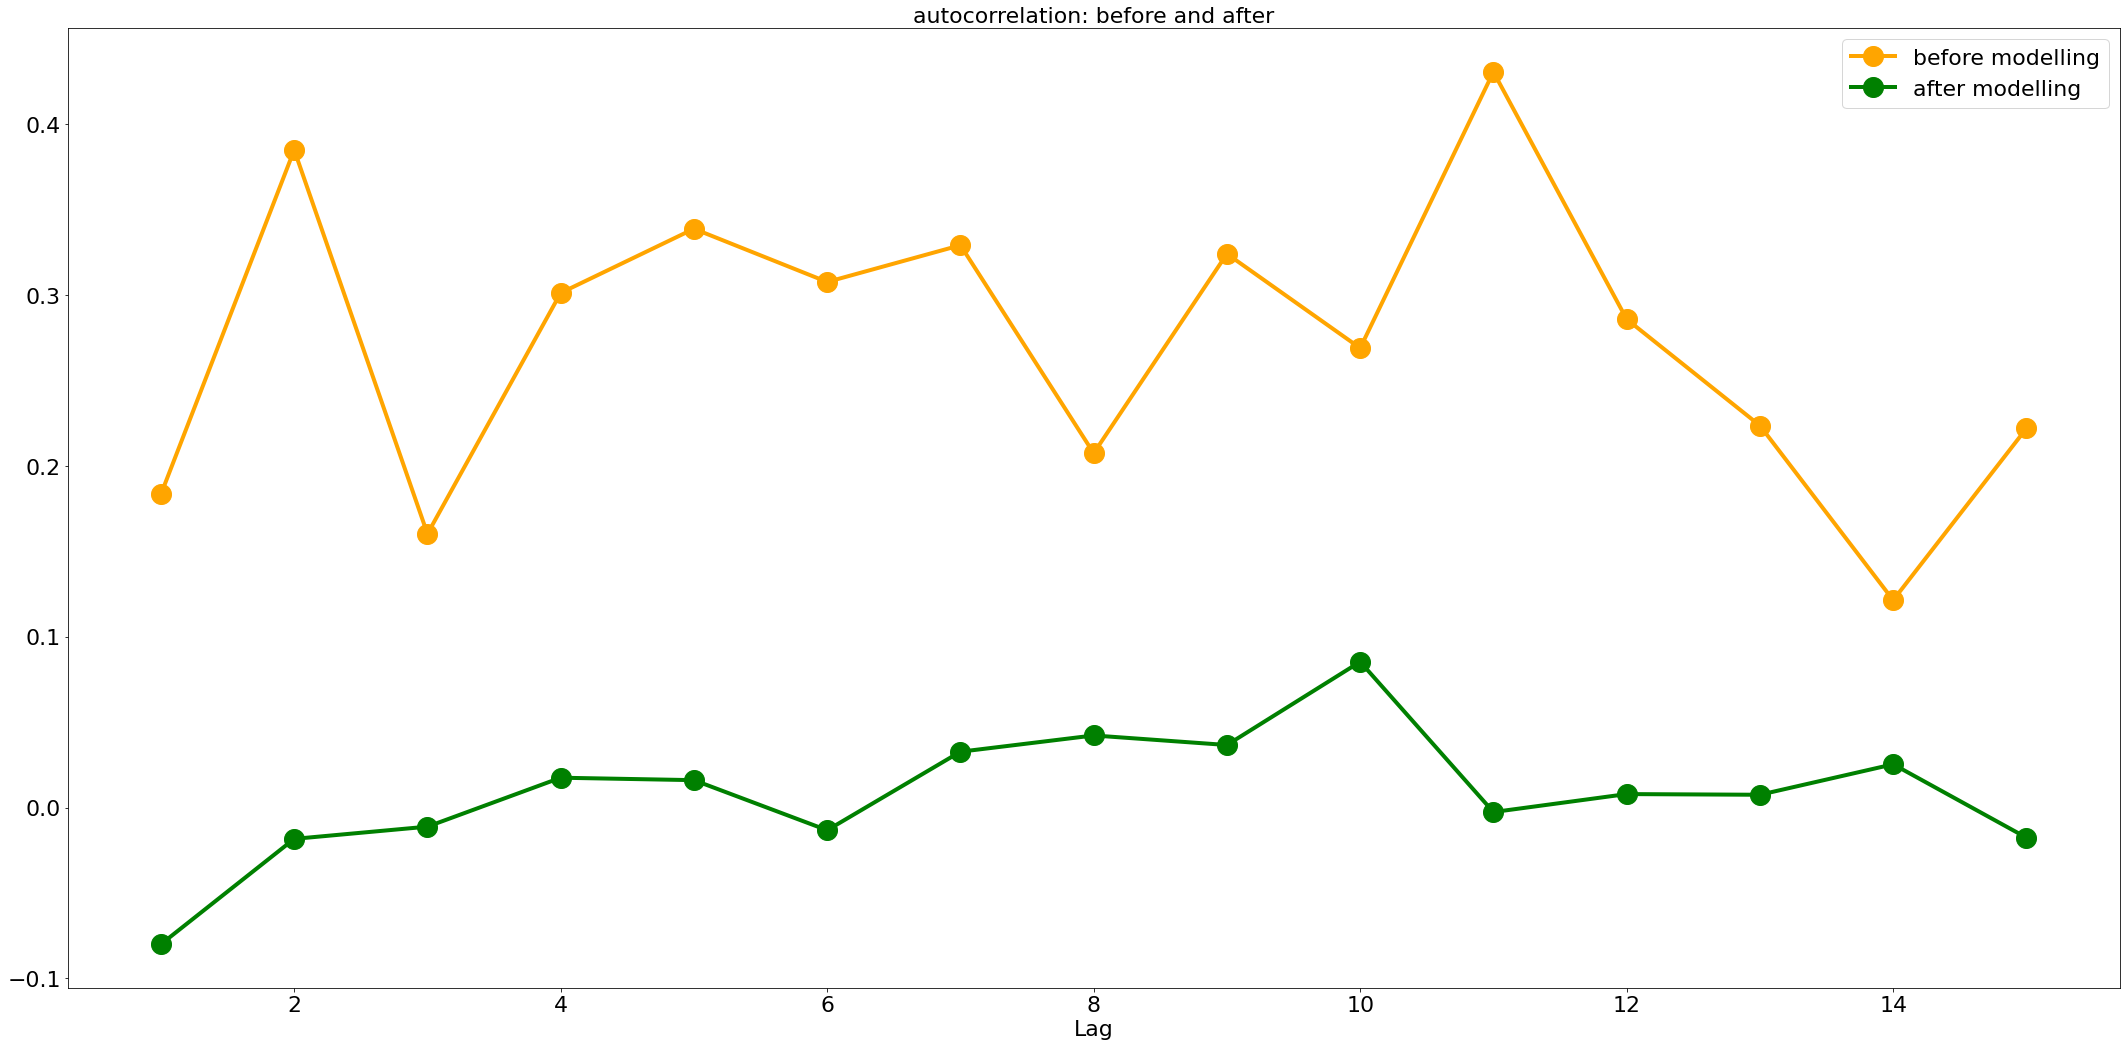

In [437]:
plt.plot([i for i in range(1,16)], auto_corr01,c='orange',linewidth=4,marker='o',markersize=20)
plt.plot([i for i in range(1,16)], auto_corr02,c='green',linewidth=4,marker='o',markersize=20)
plt.legend(['before modelling','after modelling'])
plt.rcParams["figure.figsize"] =figsize_tuple
plt.xlabel("Lag", fontsize=22)
plt.ylabel("", fontsize=18)
plt.rcParams.update({'font.size': 22})
plt.title('autocorrelation: before and after',fontsize=22)
plt.tight_layout()
plt.show()
plt.close()

In [438]:
# above chart shows after using GARCH(1,1), the autocorrelations are much smaller.